<a href="https://colab.research.google.com/github/JingwenLuo7/ComplexSystem/blob/main/Project_BlockII/PQR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Numerical Simulation of the PQR System
step 1: implement the ODEs

step 2: define parameters

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm

# Define the PQR ODE system
def model_PQR(t, y, params):
  P, Q, R = y
  a, b, V1, V2, V3, V4, K, K1, K2, K3, K4 = params

  dP_dt = a*Q - b * P/(K + P)
  dQ_dt = V1*(1 - Q)/(K1 + (1 - Q)) - V2 * R * Q/(K2 + Q)
  dR_dt = V3*P * (1 - R)/(K3 + (1 - R)) - V4 * R/(K4 + R)

  return [dP_dt, dQ_dt, dR_dt]

In [2]:
# Define parameters
a, b = 0.1, 0.1
V1, V2, V3, V4 = 1.0, 1.5, 6.0, 2.5
K, K1, K2, K3, K4 = 0.2, 0.01, 0.01, 0.01, 0.01

In [77]:
from google.colab import drive
import os

drive.mount('/content/drive')
save_directory = '/content/drive/My Drive/Colab_Figures/Project_CS/'

os.makedirs(save_directory, exist_ok=True)

full_path_figure2 = os.path.join(save_directory, 'figure2_bifurcation.jpg')
full_path_figure3a_y01 = os.path.join(save_directory, 'figure3a_time_evolution_y0_1')
full_path_figure3a_y02 = os.path.join(save_directory, 'figure3a_time_evolution_y0_2.jpg')
full_path_figure3b_y01 = os.path.join(save_directory, 'figure3b_phase_plane_y0_1.jpg')
full_path_figure3b_y02 = os.path.join(save_directory, 'figure3b_phase_plane_y0_2.jpg')
full_path_figure4 = os.path.join(save_directory, 'figure4_oscillations_v4.jpg')
full_path_figure5 = os.path.join(save_directory, 'figure5_oscillation_paras_ratio.jpg')
full_path_figure6 = os.path.join(save_directory, 'figure6_sustained_oscillations.jpg')

Mounted at /content/drive


## Figure 2. Threshold dependence of R on P and of Q on R.

step 1: calculate variable dependency in steady state using scipy.integrate.solve_ivp

step 2: find threshold values of $R^*$ and $P^*$

step 3: visualization


In [4]:
# define R dependent on P
def dR_dt(t, R, P, params):
  R = R[0]
  V3, V4, K3, K4 = params
  return V3*P * (1 - R)/(K3 + (1 - R)) - V4 * R/(K4 + R)

# define Q dependent on R
def dQ_dt(t, Q, R, params):
  Q = Q[0]
  V1, V2, K1, K2 = params
  return V1*(1 - Q)/(K1 + (1 - Q)) - V2 * R * Q/(K2 + Q)

time_span = (0, 40) # to find steady state
y0 = [0.0] # search from initial state 0

# calculate R dependent on P changes
P_vals = np.linspace(0, 1, 51) # sample P 51 times
R_ss = np.zeros_like(P_vals)
params_RP = [V3, V4, K3, K4]
for i, P in enumerate(P_vals):
  sol = solve_ivp(dR_dt, time_span, y0, args=(P,params_RP,), rtol=1e-6, atol=1e-9)
  R_ss[i] = sol.y[0, -1]

# calculate Q dependent on R changes
R_vals = np.linspace(0, 1, 51) # sample R 51 times
Q_ss = np.zeros_like(R_vals)
params_QR = [V1, V2, K1, K2]
for i, R in enumerate(R_vals):
    sol = solve_ivp(dQ_dt, time_span, y0, args=(R,params_QR,), rtol=1e-6, atol=1e-9)
    Q_ss[i] = sol.y[0, -1]

In [6]:
def find_critical_point(x, y, min_grad=0.1):
  dy_dx = np.gradient(y, x)
  max_grad_idx = np.argmax(np.abs(dy_dx))
  if np.abs(dy_dx[max_grad_idx]) < min_grad:
      return np.nan, -1

  return x[max_grad_idx], max_grad_idx

# estimate P*: the degree of cognitive restraint R is shown to rise
# abruptly when weight P exceeds the threshold value P*
P_star, P_idx = find_critical_point(P_vals, R_ss)

# estimate R*：dietary intake Q drops abruptly when R exceeds the
# threshold R*, and increases when R passes below this value.
R_star, R_idx = find_critical_point(R_vals, Q_ss)

print(f"critical point estimation: P* = {P_star:.3f}, R* = {R_star:.3f}")

critical point estimation: P* = 0.420, R* = 0.660


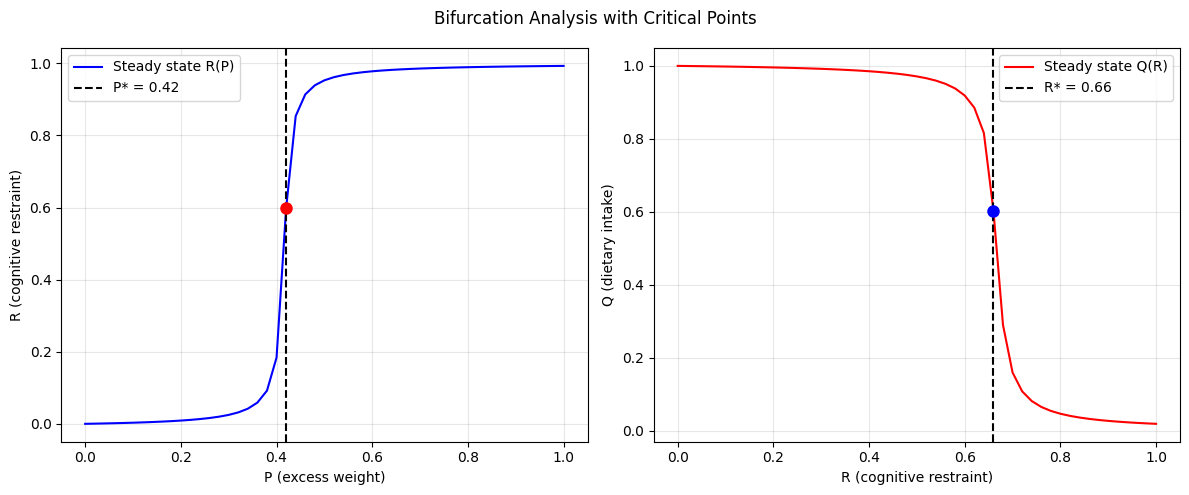

In [79]:
# visualization
plt.figure(figsize=(12,5))
# R vs P
plt.subplot(121)
plt.plot(P_vals, R_ss, 'b-', label='Steady state R(P)')
plt.xlabel('P (excess weight)')
plt.ylabel('R (cognitive restraint)')
if not np.isnan(P_star):
  plt.axvline(P_star, color='k', linestyle='--',label=f'P* = {P_star:.2f}')
  plt.plot(P_vals[P_idx], R_ss[P_idx], 'ro', markersize=8)

# Q vs R
plt.subplot(122)
plt.plot(R_vals, Q_ss, 'r-', label='Steady state Q(R)')
plt.xlabel('R (cognitive restraint)')
plt.ylabel('Q (dietary intake)')
if not np.isnan(R_star):
  plt.axvline(R_star, color='k', linestyle='--',label=f'R* = {R_star:.2f}')
  plt.plot(R_vals[R_idx], Q_ss[R_idx], 'bo', markersize=8)

# label
for ax in plt.gcf().axes:
  ax.legend(loc='best')
  ax.grid(True, alpha=0.3)

plt.suptitle('Bifurcation Analysis with Critical Points')
plt.tight_layout()
plt.savefig(full_path_figure2, dpi=300, bbox_inches='tight')
plt.show()

## Figure 3. Sustained oscillations generated by the model for weight cycling.

Figure 3A.
1. Time evolution Lines:
  - excess weight P (in blue),
  - degree R of cognitive restraint (in green)
  - fraction Q of maximum dietary intake in excess of a basal value (in red).
2. initial states for P, Q, R
  - y0_1 = [0.43, 0.90, 0.60]
  - y0_2 = [0.43, 0.80, 0.05]

In [82]:
def plot_timeEvo(P,Q,R,t,path):
  fig, ax = plt.subplots(figsize=(8, 5))

  # curves for P, Q, R
  ax.plot(t, P, color='blue', linestyle='-')
  ax.plot(t, Q, color='red', linestyle='-')
  ax.plot(t, R, color='green', linestyle='-')

  # axis label
  ax.set_xlabel('Time', fontsize=12)
  ax.set_ylabel('Value', fontsize=12)
  ax.text(0.5, 1.08, 'Time Evolution of P, Q, and R',
          horizontalalignment='center', transform=ax.transAxes, fontsize=16)
  ax.text(0.5, 1.02, f'Initial conditions: P={P[0]}, Q={Q[0]}, R={R[0]}',
          horizontalalignment='center', transform=ax.transAxes, fontsize=10)

  # legend
  blue_line = mlines.Line2D([], [], color='blue', label='P (excess weight)')
  red_line = mlines.Line2D([], [], color='red', label='Q (dietary intake)')
  green_line = mlines.Line2D([], [], color='green', label='R (cognitive restraint)')
  ax.legend(handles=[blue_line, red_line, green_line],
            loc='upper right',frameon=False, fontsize=10,
            bbox_to_anchor=(1.35, 0.95))

  plt.tight_layout()
  plt.subplots_adjust(right=0.85)
  plt.savefig(path, dpi=300, bbox_inches='tight')
  plt.show()

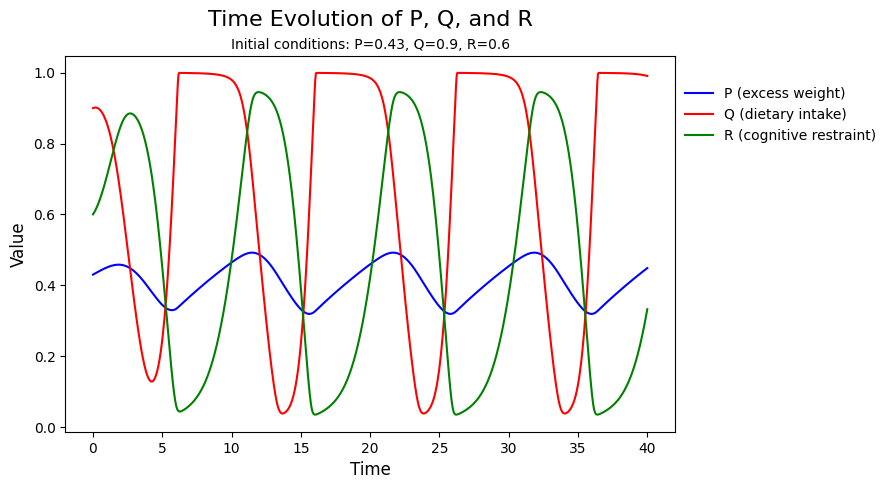

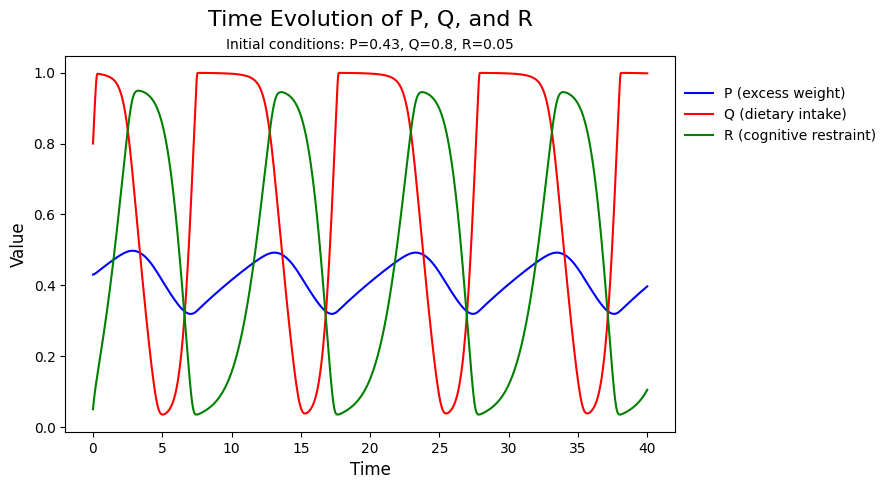

In [86]:
# Time span and evaluation points
t_span = (0, 40)
t_eval = np.linspace(*t_span, 1001)

# Initial conditions (two sets)
y0_1 = [0.43, 0.90, 0.60]
y0_2 = [0.43, 0.80, 0.05]

# Integrate the ODE for both sets
params = [a, b, V1, V2, V3, V4, K, K1, K2, K3, K4]
sol1 = solve_ivp(model_PQR, t_span, y0_1, args=(params,), t_eval=t_eval, rtol=1e-6)
sol2 = solve_ivp(model_PQR, t_span, y0_2, args=(params,), t_eval=t_eval, rtol=1e-6)

# Extract solutions
P1, Q1, R1 = sol1.y
P2, Q2, R2 = sol2.y

# Plot P, Q, R over time
plot_timeEvo(P1,Q1,R1,sol1.t,full_path_figure3a_y01)
plot_timeEvo(P2,Q2,R2,sol1.t,full_path_figure3a_y02)

Figure 3B

The oscillations correspond to the evolution towards a limit cycle shown here in the (P, R) plane as a projection of the trajectory followed by the 3-variable system governed by eqs (1a-c).

The same closed curve, known as a limit cycle, is reached from two distinct initial conditions:
  - P=0.43, Q=0.9, R=0.6 (green trajectory)
  - P=0.43, Q=0.8, R=0.05 (blue trajectory, which merges with the green one)

corresponding to points located inside and outside the limit cycle, respectively.

To match typical durations of weight cycles, time in (A) should be expressed in units of the order of one week to one month.

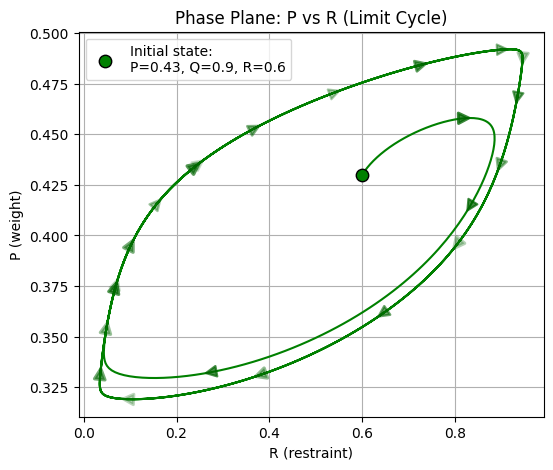

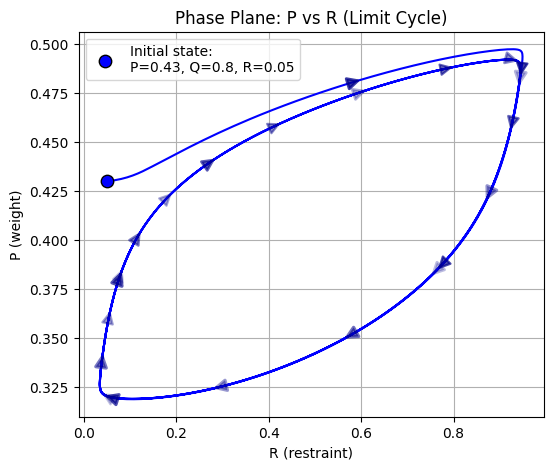

In [88]:
def plot_traj(R,P,c,l,PATH):
  plt.figure(figsize=(6,5))
  # Plot the trajectories in P-R plane
  plt.plot(R, P, color = c, zorder=2)
  # Mark initial points
  plt.scatter(R[0], P[0], color=c, edgecolors='k', s=80,
                zorder=5, label=f'Initial state:\n{l}')
  # add arrow
  n_points = len(R)
  arrow_step = max(1, n_points//22)  # one arrow for every 22 points
  for i in range(arrow_step, n_points-1, arrow_step):
    # arrow position
    mid_x = (R[i] + R[i+1])/2
    mid_y = (P[i] + P[i+1])/2
    # calculate direction
    dx = R[i+1] - R[i]
    dy = P[i+1] - P[i]
    # plot arrow
    plt.annotate('', # label
      xytext=(mid_x - 0.2*dx, mid_y - 0.2*dy),
      xy=(mid_x + 0.2*dx, mid_y + 0.2*dy),
      arrowprops=dict(
        arrowstyle='simple,head_length=0.5,head_width=0.5,tail_width=0.3',
        color=f'dark{c}',mutation_scale=15,
        lw=2+ 0.5*np.cos(i/4),alpha=0.8 - 0.6*(i/len(R)),
      ),zorder=3)
  plt.ylabel('P (weight)')
  plt.xlabel('R (restraint)')
  plt.title('Phase Plane: P vs R (Limit Cycle)')
  plt.legend()
  plt.grid(True)
  plt.savefig(PATH, dpi=300, bbox_inches='tight')
  plt.show()

label_y01 = 'P=0.43, Q=0.9, R=0.6'
label_y02 = 'P=0.43, Q=0.8, R=0.05'

plot_traj(R1,P1,'green',label_y01,full_path_figure3b_y01)
plot_traj(R2,P2,'blue',label_y02,full_path_figure3b_y02)

## Figure 4. Domain of occurrence of weight cycling as a function of parameter $V_4$

$V_4$ measures the rate of waning of the resolution to reduce dietary intake by cognitive restraint.

Figure 4 Shows the family of curves that represent the time evolution of excess weight $P$ for $V_4$ increasing from 0.1 (lowest curve) to 10 (upper curve) by  9 steps of 1.1.
  - For $V_4=0.1$ (first curve from the bottom) a stable  steady state corresponding to a low value of P is reached.
  - For $V_4 > 9.4$, excess weight stabilizes at a relatively larger value.

In the interval between these two critical values of $V_4$, sustained oscillations in P corresponding to weight cycling occur.

Both the latency (i.e. the time to the first peak in P) and the mean level of the oscillations increase with parameter $V_4$.

The curves are obtained by  numerical integration of eqs (1a-c), using the parameter values of figures 2 and 3. Initial conditions are P=0.25, Q=0.9, R=0.02.

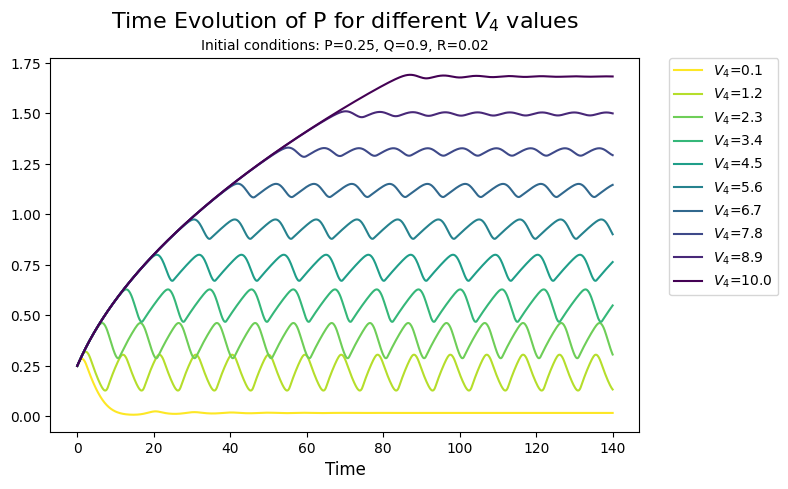

In [85]:
def plot_timeEvo_v4(v4_vals,PATH):
  # Time span and evaluation points
  t_span = (0, 140)
  t_eval = np.linspace(*t_span, 1001)

  # Initial conditions
  y0 = [0.25, 0.90, 0.02]

  fig, ax = plt.subplots(figsize=(8, 5))
  colors = cm.viridis(np.linspace(1, 0, len(v4_vals)))
  for i, v4 in enumerate(v4_vals):
    params = [a, b, V1, V2, V3, v4, K, K1, K2, K3, K4]
    sol = solve_ivp(model_PQR, t_span, y0, args=(params,), t_eval=t_eval, rtol=1e-6)
    P = sol.y[0]
    # plot curves for P
    ax.plot(sol.t, P, linestyle='-', color=colors[i], label=f'$V_4$={v4:.1f}')

  # label
  ax.set_xlabel('Time', fontsize=12)
  ax.text(0.5, 1.08, 'Time Evolution of P for different $V_4$ values',
          horizontalalignment='center', transform=ax.transAxes, fontsize=16)
  ax.text(0.5, 1.02, f'Initial conditions: P={y0[0]}, Q={y0[1]}, R={y0[2]}',
          horizontalalignment='center', transform=ax.transAxes, fontsize=10)
  ax.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  plt.tight_layout()
  plt.savefig(PATH, dpi=300, bbox_inches='tight')
  plt.show()

v4_vals = np.arange(0.1, 10.1, 1.1)
plot_timeEvo_v4(v4_vals,full_path_figure4)

C:\Users\95168\AppData\Local\Temp\ipykernel_20560\488405041.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  M1 = P / (K1 + P)
C:\Users\95168\AppData\Local\Temp\ipykernel_20560\488405041.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  M2 = P / (K2 + P)
C:\Users\95168\AppData\Local\Temp\ipykernel_20560\488405041.py:7: RuntimeWarning: invalid value encountered in scalar divide
  M3 = R / (K3 + R)
C:\Users\95168\AppData\Local\Temp\ipykernel_20560\488405041.py:8: RuntimeWarning: invalid value encountered in scalar divide
  M4 = R / (K4 + R)


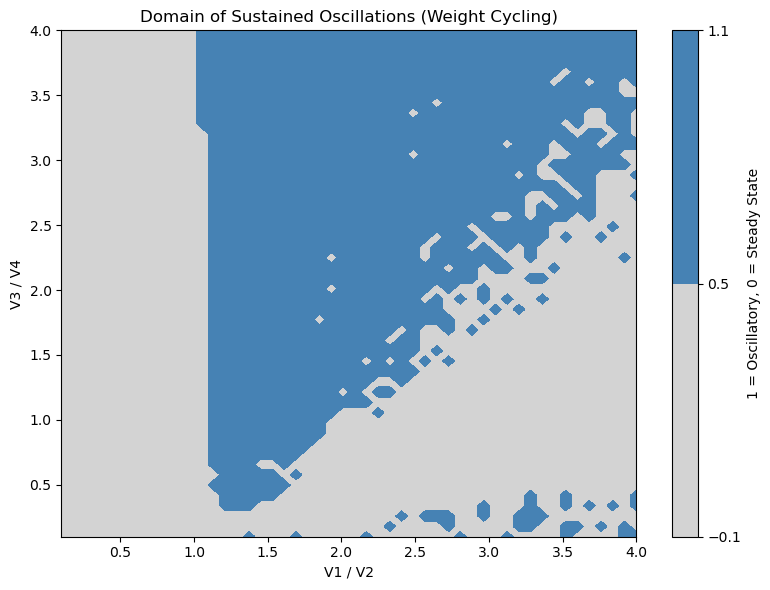

In [ ]:
def is_oscillatory(sol, threshold=0.02):
    P = sol.y[0]
    last_window = P[-100:]
    return np.ptp(last_window) > threshold  # peak-to-peak > threshold


def plot_weight_cycling_domain():
    # 固定值
    a = b = 0.1
    V2 = 1.5
    V4 = 2.5
    K = 0.2
    K1 = K2 = K3 = K4 = 0.01

    # 扫描参数比值
    V1_V2_vals = np.linspace(0.1, 4.0, 50)
    V3_V4_vals = np.linspace(0.1, 4.0, 50)

    result_matrix = np.zeros((len(V3_V4_vals), len(V1_V2_vals)))

    t_span = (0, 1000)
    t_eval = np.linspace(*t_span, 2000)
    y0 = [0.25, 0.9, 0.02]

    for i, V1_V2 in enumerate(V1_V2_vals):
        V1 = V1_V2 * V2
        for j, V3_V4 in enumerate(V3_V4_vals):
            V3 = V3_V4 * V4
            params = [a, b, V1, V2, V3, V4, K, K1, K2, K3, K4]
            sol = solve_ivp(model, t_span, y0, args=(params,), t_eval=t_eval)
            result_matrix[j, i] = 1 if is_oscillatory(sol) else 0

    # 绘图
    plt.figure(figsize=(8, 6))
    plt.contourf(V1_V2_vals, V3_V4_vals, result_matrix, levels=[-0.1, 0.5, 1.1], colors=['lightgrey', 'steelblue'])
    plt.xlabel('V1 / V2')
    plt.ylabel('V3 / V4')
    plt.title('Domain of Sustained Oscillations (Weight Cycling)')
    plt.colorbar(label='1 = Oscillatory, 0 = Steady State')
    plt.tight_layout()
    plt.show()

plot_weight_cycling_domain()


In [ ]:
# 固定参数值
a = b = 0.1
V2 = 1.5
V4 = 2.5
K = 0.2
K1 = K2 = K3 = K4 = 0.01

# 横纵坐标范围：V1/V2 和 V3/V4
V1_V2_vals = np.linspace(0.1, 4.0, 50)
V3_V4_vals = np.linspace(0.1, 4.0, 50)

result_matrix = np.zeros((len(V3_V4_vals), len(V1_V2_vals)))

# 初始条件
y0 = [0.25, 0.9, 0.02]
t_span = (0, 1000)
t_eval = np.linspace(*t_span, 2000)

for i, V1_V2 in enumerate(V1_V2_vals):
    V1 = V1_V2 * V2
    for j, V3_V4 in enumerate(V3_V4_vals):
        V3 = V3_V4 * V4
        params = [a, b, V1, V2, V3, V4, K, K1, K2, K3, K4]

        try:
            sol = solve_ivp(model, t_span, y0, args=(params,), t_eval=t_eval, rtol=1e-6, atol=1e-8)
            result_matrix[j, i] = 1 if is_oscillatory(sol) else 0
        except:
            result_matrix[j, i] = np.nan  # 用于捕捉收敛失败的点

# 绘图
plt.figure(figsize=(8, 6))
plt.contourf(V1_V2_vals, V3_V4_vals, result_matrix, levels=[-0.1, 0.5, 1.1], colors=["lightgrey", "steelblue"])
plt.xlabel("V1 / V2")
plt.ylabel("V3 / V4")
plt.title("Figure 5: Domain of Weight Cycling in (V1/V2, V3/V4) Space")
cbar = plt.colorbar()
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Steady state", "Weight cycling"])
plt.tight_layout()
plt.show()


振荡域布尔矩阵 (True 表示振荡):
[[1 1 0 1 1]
 [1 1 0 0 0]
 [1 1 0 0 0]
 [1 1 0 0 0]
 [1 1 0 0 0]]
